# Data
* 82 patients 
* Images taken at different magnifying factors (40X, 100X, 200X, and 400X)
* 2,480  benign and 5,429 malignant samples 
* 700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format
* Samples collected by SOB method, also named partial mastectomy or excisional biopsy (bigger than needle samples)

### Classes
#### Benign Tumors

* **Adenosis (A)**-  breast lobules (milk-producing glands) are enlarged
* **Fibroadenoma (F)**- common benign (non-cancer) tumors made up of both glandular breast tissue and stromal(connective) tissue. 
* **Phyllodes tumor (PT)** -  rare breast tumors that start in the connective (stromal) tissue of the breast. About 1 out of 10 of these tumors are malignant
* **Tubular adenona (TA)**-  ???

#### Malignant Tumors

* **Carcinoma (DC)** - Cancer beginning in the milk ducts. About 80% of all breast cancers are invasive ductal carcinomas.
* **Lobular carcinoma (LC)** - Cancer began in the milk-producing lobules. About 10% of all invasive breast cancers. 
* **Mucinous carcinoma (MC)** - Rare form of invasive ductal carcinoma, where the tumor is made up of abnormal cells that “float” in pools of mucin, a key ingredient in the slimy, slippery substance known as mucus.
* **Papillary carcinoma (PC)** - 1-2% of invasive breast cancers. Well-defined border and is made up of small, finger-like projections. In most cases of invasive papillary carcinoma, ductal carcinoma in situ (DCIS)
(cancer.org, breastcancer.org)

Malignant - best to classify into 2 types, and classify everything else as other.
Carcinoma (DC) or Lobular carcinoma. 

Treatment is similair for all invasive, but Lobular is more likely to be on both sides. 

More agressive (grade 3) cancers are more likely to spread.

In [19]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
from PIL import Image

% matplotlib inline

from shutil import copyfile

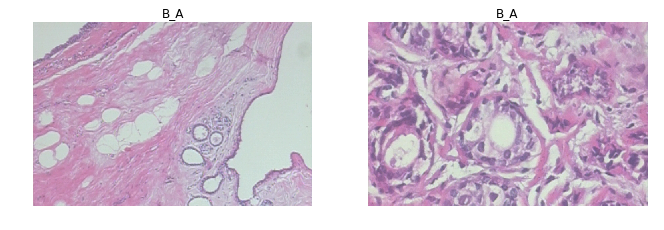

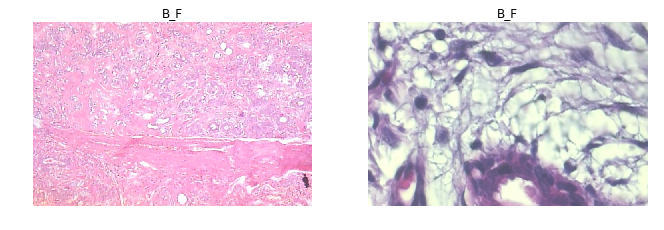

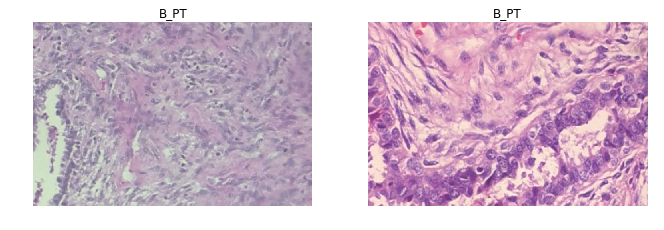

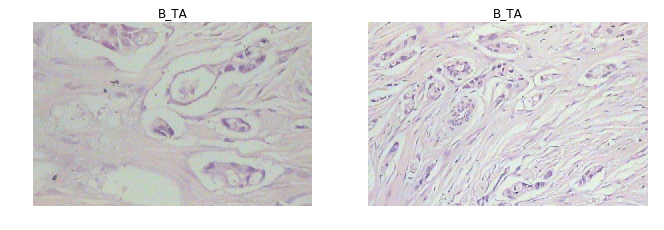

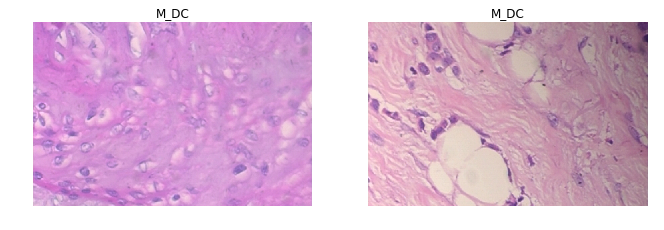

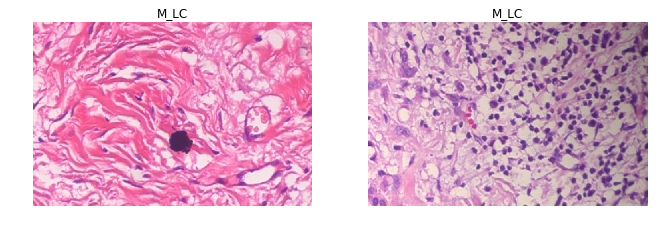

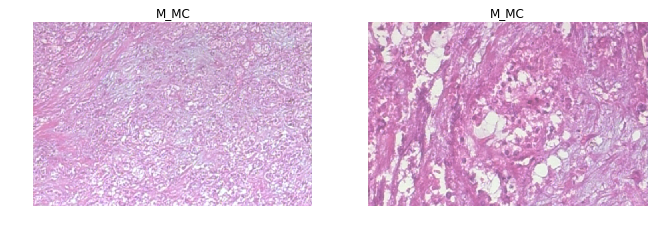

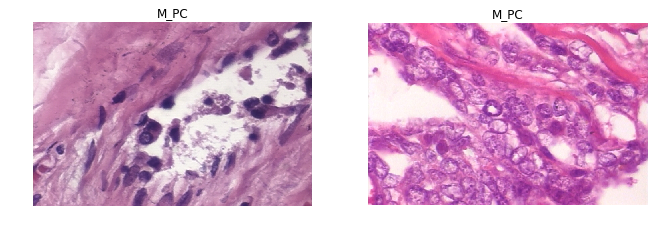

In [61]:
# Look at a few examples:
loc = '/Users/rb/Documents/waterloo/projects/breakHis/BreaKHis_v1'
all_image_locs = glob.glob(loc +'/**/*.png', recursive=True)

classes = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']

for slide_class in classes:
    image_locs = [loc for loc in all_image_locs if loc.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0] == slide_class]
    image_locs = np.random.choice(image_locs, 2)

    f = plt.figure(figsize=(11,8))
    for i in range(len(image_locs)):
        sp = f.add_subplot(2, len(image_locs)//1, i+1)
        sp.axis('Off')
        sp.set_title(image_locs[i].rsplit('/', 1)[-1], fontsize=10)
        image = np.asarray(Image.open(image_locs[i]))
        plt.title(slide_class)

        #plt.tight_layout()
        plt.imshow(image)

## Some patients have 2 types

In [43]:
train_loc = '/Users/rb/Documents/waterloo/projects/breakHis/mkfold_keras8/fold1/100/'
all_train = glob.glob(train_loc+'/**/*.png', recursive=True)

all_ids = [loc.rsplit('/', 1)[1].split('-', 3)[2] for loc in all_train]
all_ids = list(set(all_ids))

for ID in all_ids:
    files = [loc for loc in all_train if loc.rsplit('/', 1)[1].split('-', 3)[2] in ID]
    class_ids = [loc.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0] for loc in files]
    if len(list(set(class_ids)))>1:
        print('Patient ID: ', ID, 'classes: ', list(set(class_ids)))

Patient ID:  13412 classes:  ['M_LC', 'M_DC']
Patient ID:  12773 classes:  ['M_MC', 'M_DC']


# 5-Fold CV
* Using the exact folds defined in the dataset
* Create a validation folder which is 20% of the train set
* Not sure if best to seperate patients between validation and training set. Data leakage if not seperated, but if it is there will be missing classes in validation. 
* We go with seperate. There will be disaster if it learns to discriminate based on color of slides. Maybe should test this...
* Also stratify by tumor class to keep examples in the validation set.

To stratify the samples for a given fold and magnification:
1. For each tumor class find the unique IDs
2. Take 20% of these IDs as validation, the rest as training. 
3. Copy all of each ID's images into the correct folder.
4. Assume only one class for each ID

In [71]:
in_loc = '/Users/rb/Documents/waterloo/projects/breakHis/mkfold'
out_loc = '/Users/rb/Documents/waterloo/projects/breakHis/mkfold_keras_8im'

all_files = glob.glob(in_loc+'/**/*.png', recursive=True)

for file in all_files:
    name = file.rsplit('/', 1)[1]
    fold = file.rsplit('mkfold/', 1)[1].split('/', 1)[0]
    ttv_dir = file.rsplit('mkfold/', 1)[1].split('/', 1)[1].split('/', 1)[0]
    zoom = file.rsplit('/', 1)[1].rsplit('-', 1)[0].rsplit('-', 1)[1]
    tumor_class = file.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0]
    new_folder = os.path.join(out_loc, fold, zoom, ttv_dir, tumor_class)
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)
    copyfile(file, os.path.join(new_folder, name))

valid_proportion = .8

# Now for each fold, and at each magnification, add a validation folder and take 20% of the train set for it
for fold in ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']:
    for mag in ['40', '100', '200', '400']:
        train_loc = os.path.join(out_loc, fold, mag, 'train')
        valid_loc = os.path.join(out_loc, fold, mag, 'valid')
        if not os.path.exists(valid_loc):
            os.makedirs(valid_loc)
        all_train = glob.glob(train_loc+'/**/*.png', recursive=True)

        # Get all the patients:
        all_ids = [loc.rsplit('/', 1)[1].split('-', 3)[2] for loc in all_train]
        all_ids = list(set(all_ids))
        print('Number of Patients in ', fold, ' magnification ', mag,  ' : ',  len(all_ids))

        # Get all the tumor classes, and stratify the patients so test and valid sets contain at least one from each type
        tumor_class_list = list(set([loc.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0] for loc in all_train]))

        for tumor_class in tumor_class_list:
            new_folder = os.path.join(valid_loc, tumor_class)
            if not os.path.exists(new_folder):
                os.makedirs(new_folder)

            # for each tumor class find all the patients, and split the patients into train and valid
            class_ids = [loc.rsplit('/', 1)[1].split('-', 3)[2] for loc in all_train if loc.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0] == tumor_class]
            random.shuffle(class_ids)
            class_ids = list(set(class_ids))

            valid_ids = class_ids[int(np.floor(len(class_ids)*valid_proportion)):]
            # add only if both the id is correct, and if the type is correct. (some patients have 2 types)
            valid_files = [loc for loc in all_train if loc.rsplit('/', 1)[1].split('-', 3)[2] in valid_ids and loc.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0] == tumor_class]

            # copy the validation files into the new directory, and delete them from the training 
            for file in valid_files:
                name = file.rsplit('/', 1)[1]
                copyfile(file, os.path.join(new_folder, name))
                os.remove(file)
            #print('Number of patients of type ',  tumor_class, ' is: ', num_ids, ' Valid: ', len(valid_files))

Number of Patients in  fold1  magnification  40  :  54
Number of Patients in  fold1  magnification  100  :  54
Number of Patients in  fold1  magnification  200  :  54
Number of Patients in  fold1  magnification  400  :  54
Number of Patients in  fold2  magnification  40  :  53
Number of Patients in  fold2  magnification  100  :  53
Number of Patients in  fold2  magnification  200  :  53
Number of Patients in  fold2  magnification  400  :  53
Number of Patients in  fold3  magnification  40  :  54
Number of Patients in  fold3  magnification  100  :  54
Number of Patients in  fold3  magnification  200  :  54
Number of Patients in  fold3  magnification  400  :  54
Number of Patients in  fold4  magnification  40  :  53
Number of Patients in  fold4  magnification  100  :  53
Number of Patients in  fold4  magnification  200  :  53
Number of Patients in  fold4  magnification  400  :  53
Number of Patients in  fold5  magnification  40  :  54
Number of Patients in  fold5  magnification  100  :  

## Train/test/valid without CV
* Keras directory format - folder for each type 
* Split this by patient, so no data leakage
* Some classes have few examples - try to distribute so each class represented in test, train, valid (only close 
* Assume on an image SOB_M_PC-14-15687B-200-004.png that -15687B- is the patient id

In [38]:
def train_test_valid_split(current_dir, out_dir, valid_proportion, test_proportion):
    # Make directories to store files        
    train_dir=os.path.join(out_dir, 'train')
    valid_dir=os.path.join(out_dir, 'valid')
    test_dir=os.path.join(out_dir, 'test')
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(valid_dir):
        os.makedirs(valid_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    
    all_files = glob.glob(current_dir+'/**/*.png', recursive=True)
    all_files = [loc for loc in all_files if loc.split('.', 1)[-1] == 'png']
    print('len(all_files): ', len(all_files))
    
    # get all the patient ids
    all_ids = [loc.rsplit('/', 1)[1].split('-', 3)[2] for loc in all_files]
    all_ids = list(set(all_ids))
    print('Number of Patients: ',  len(all_ids))

    # Get all the tumor classes, and stratify the patients so test and valid sets contain at least one from each type
    tumor_class_list = list(set([loc.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0] for loc in all_files]))

    for tumor_class in tumor_class_list:
        # for each tumor class find all the patients, and randomly split up the patients into test, train, valid
        class_ids = [loc.rsplit('/', 1)[1].split('-', 3)[2] for loc in all_files if loc.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0] == tumor_class]
        random.shuffle(class_ids)
        class_ids = list(set(class_ids))
        num_ids = len(class_ids)
        print('Number of Patients of type ',  tumor_class, ' is: ', num_ids)

        valid_ids = list(set(class_ids[0:int(np.ceil(num_ids*valid_proportion))]))
        test_ids = list(set(class_ids[int(np.ceil(num_ids*valid_proportion)) : int(np.ceil(num_ids*(valid_proportion+test_proportion)))]))
        train_ids = list(set(class_ids[int(np.ceil(num_ids*(valid_proportion+test_proportion))):]))

        print('len(train_ids)', len(train_ids))
        print('len(test_ids)', len(test_ids))
        print('len(valid_ids)', len(valid_ids))

        train_files = [loc for loc in all_files if loc.rsplit('/', 1)[1].split('-', 3)[2] in train_ids]
        test_files = [loc for loc in all_files if loc.rsplit('/', 1)[1].split('-', 3)[2] in test_ids]
        valid_files = [loc for loc in all_files if loc.rsplit('/', 1)[1].split('-', 3)[2] in valid_ids]

        print('len(train_files)', len(train_files))
        print('len(test_files)', len(test_files))
        print('len(valid_files)', len(valid_files))

        # for each of train, test, valid make directories for each class, and copy the 
        for file in train_files:
            name = file.rsplit('/', 1)[1]
            tumor_class = file.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0]
            new_folder = os.path.join(train_dir, tumor_class)
            if not os.path.exists(new_folder):
                os.makedirs(new_folder)
            copyfile(file, os.path.join(new_folder, name))

        for file in valid_files:
            name = file.rsplit('/', 1)[1]
            tumor_class = file.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0]
            new_folder = os.path.join(valid_dir, tumor_class)
            if not os.path.exists(new_folder):
                os.makedirs(new_folder)
            copyfile(file, os.path.join(new_folder, name))

        for file in test_files:
            name = file.rsplit('/', 1)[1]
            tumor_class = file.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0]
            new_folder = os.path.join(test_dir, tumor_class)
            if not os.path.exists(new_folder):
                os.makedirs(new_folder)
            copyfile(file, os.path.join(new_folder, name))

In [39]:
# create the main sets:
current_dir = '/Users/rb/Documents/waterloo/projects/breakHis/BreaKHis_v1'
out_dir = '/Users/rb/Documents/waterloo/projects/breakHis/by_patient'
valid_proportion = .2
test_proportion = .2

# train_test_valid_split(current_dir, out_dir, valid_proportion, test_proportion)

len(all_files):  7909
Number of Patients:  81
Number of Patients of type  B_TA  is:  7
len(train_ids) 4
len(test_ids) 1
len(valid_ids) 2
len(train_files) 385
len(test_files) 53
len(valid_files) 131
Number of Patients of type  M_LC  is:  5
len(train_ids) 3
len(test_ids) 1
len(valid_ids) 1
len(train_files) 474
len(test_files) 74
len(valid_files) 201
Number of Patients of type  M_DC  is:  38
len(train_ids) 22
len(test_ids) 8
len(valid_ids) 8
len(train_files) 2105
len(test_files) 774
len(valid_files) 695
Number of Patients of type  M_PC  is:  6
len(train_ids) 3
len(test_ids) 1
len(valid_ids) 2
len(train_files) 266
len(test_files) 142
len(valid_files) 152
Number of Patients of type  M_MC  is:  9
len(train_ids) 5
len(test_ids) 2
len(valid_ids) 2
len(train_files) 392
len(test_files) 160
len(valid_files) 240
Number of Patients of type  B_PT  is:  3
len(train_ids) 1
len(test_ids) 1
len(valid_ids) 1
len(train_files) 60
len(test_files) 235
len(valid_files) 158
Number of Patients of type  B_A  is:

## Seperate files for each magnification:

In [17]:
loc = '/Users/rb/Documents/waterloo/projects/breakHis/by_patient'
out_loc = '/Users/rb/Documents/waterloo/projects/breakHis/by_patient_zoom'

all_files = glob.glob(loc+'/**/*.png', recursive=True)

for file in all_files:
    name = file.rsplit('/', 1)[1]
    ttv_dir = file.rsplit('by_patient/', 1)[1].split('/', 1)[0]
    zoom = file.rsplit('/', 1)[1].rsplit('-', 1)[0].rsplit('-', 1)[1]
    tumor_class = file.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0]
    new_folder = os.path.join(out_loc, zoom, ttv_dir, tumor_class)
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)
    copyfile(file, os.path.join(new_folder, name))

## Test/train/valid without keras dir format. Keep the labels

In [44]:
def train_test_valid_split(current_dir, out_dir, valid_proportion, test_proportion):
    # Make directories to store files        
    train_dir=os.path.join(out_dir, 'train')
    valid_dir=os.path.join(out_dir, 'valid')
    test_dir=os.path.join(out_dir, 'test')
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(valid_dir):
        os.makedirs(valid_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    
    all_files = glob.glob(current_dir+'/**/*.png', recursive=True)
    all_files = [loc for loc in all_files if loc.split('.', 1)[-1] == 'png']
    print('len(all_files): ', len(all_files))
    
    # get all the patient ids
    all_ids = [loc.rsplit('/', 1)[1].split('-', 3)[2] for loc in all_files]
    all_ids = list(set(all_ids))
    print('Number of Patients: ',  len(all_ids))

    # Get all the tumor classes, and stratify the patients so test and valid sets contain at least one from each type
    tumor_class_list = list(set([loc.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0] for loc in all_files]))

    for tumor_class in tumor_class_list:
        # for each tumor class find all the patients, and randomly split up the patients into test, train, valid
        class_ids = [loc.rsplit('/', 1)[1].split('-', 3)[2] for loc in all_files if loc.rsplit('/', 1)[1].split('_', 1)[1].split('-', 1)[0] == tumor_class]
        random.shuffle(class_ids)
        class_ids = list(set(class_ids))
        num_ids = len(class_ids)
        print('Number of Patients of type ',  tumor_class, ' is: ', num_ids)

        valid_ids = list(set(class_ids[0:int(np.ceil(num_ids*valid_proportion))]))
        test_ids = list(set(class_ids[int(np.ceil(num_ids*valid_proportion)) : int(np.ceil(num_ids*(valid_proportion+test_proportion)))]))
        train_ids = list(set(class_ids[int(np.ceil(num_ids*(valid_proportion+test_proportion))):]))

        print('len(train_ids)', len(train_ids))
        print('len(test_ids)', len(test_ids))
        print('len(valid_ids)', len(valid_ids))

        train_files = [loc for loc in all_files if loc.rsplit('/', 1)[1].split('-', 3)[2] in train_ids]
        test_files = [loc for loc in all_files if loc.rsplit('/', 1)[1].split('-', 3)[2] in test_ids]
        valid_files = [loc for loc in all_files if loc.rsplit('/', 1)[1].split('-', 3)[2] in valid_ids]

        print('len(train_files)', len(train_files))
        print('len(test_files)', len(test_files))
        print('len(valid_files)', len(valid_files))

        # for each of train, test, valid copy the files over, keeping the full name
        for file in train_files:
            name = file.rsplit('/', 1)[1]
            copyfile(file, os.path.join(train_dir, name))

        for file in valid_files:
            name = file.rsplit('/', 1)[1]
            copyfile(file, os.path.join(valid_dir, name))

        for file in test_files:
            name = file.rsplit('/', 1)[1]
            copyfile(file, os.path.join(test_dir, name))

In [27]:
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=True)
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_189 (Conv2D)              (None, 149, 149, 32)  864         input_3[0][0]                    
____________________________________________________________________________________________________
batch_normalization_189 (BatchNo (None, 149, 149, 32)  96          conv2d_189[0][0]                 
____________________________________________________________________________________________________
activation_189 (Activation)      (None, 149, 149, 32)  0           batch_normalization_189[0][0]    
___________________________________________________________________________________________

In [10]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_3
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [41]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

vgg16 = VGG16(weights='imagenet')
vgg16.save('/Users/rb/Documents/waterloo/projects/models/vgg16')

InceptionV3 = InceptionV3(weights='imagenet', include_top=False)
InceptionV3.save('/Users/rb/Documents/waterloo/projects/models/InceptionV3')

In [24]:
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=True)
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________